In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
# Load metadata
file_path = "C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer/release_midas.xlsx"
df = pd.read_excel(file_path)

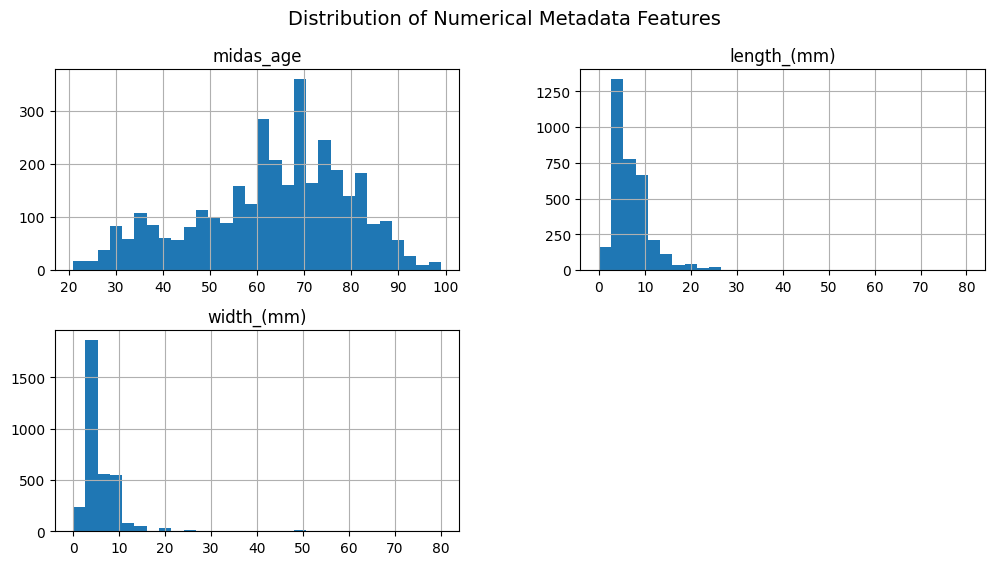

In [4]:
# Plot histograms for numerical columns
numerical_cols = ['midas_age', 'length_(mm)', 'width_(mm)']
df[numerical_cols].hist(figsize=(12, 6), bins=30)
plt.suptitle("Distribution of Numerical Metadata Features", fontsize=14)
plt.show()

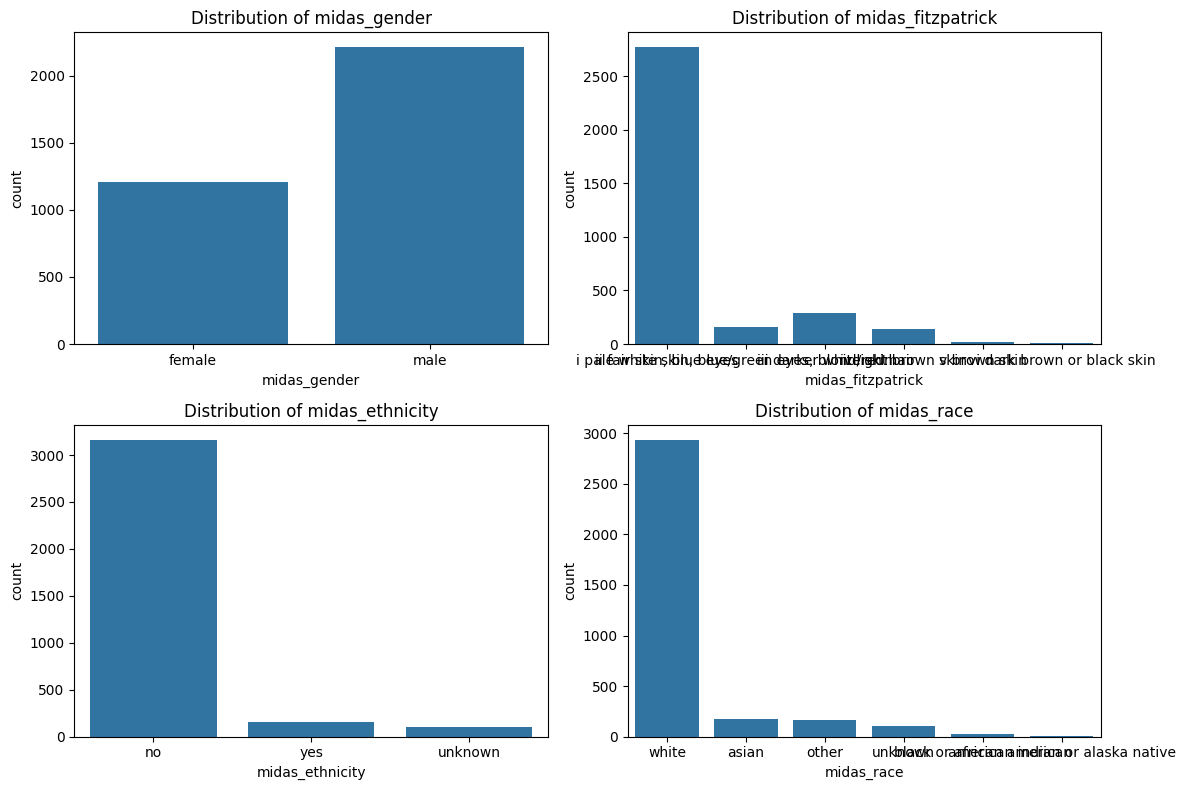

In [5]:
categorical_cols = ['midas_gender', 'midas_fitzpatrick', 'midas_ethnicity', 'midas_race']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


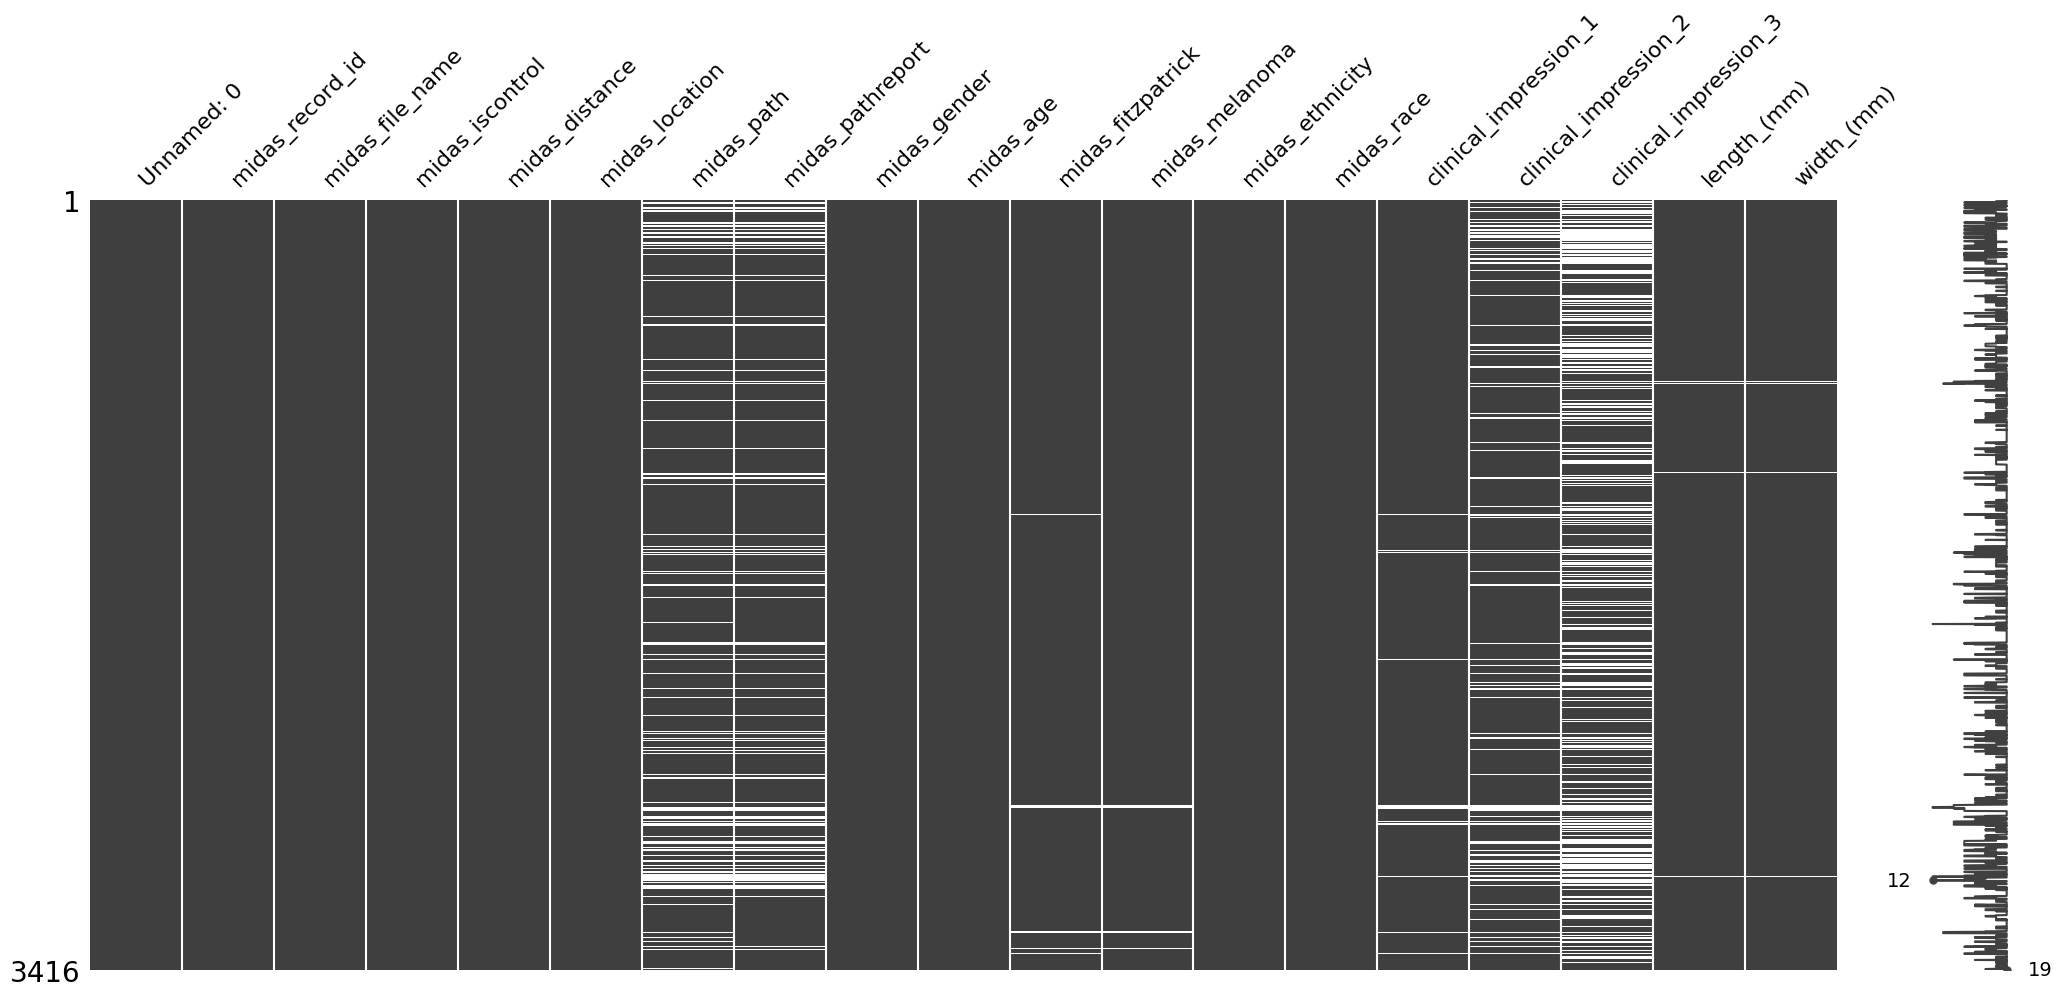

In [6]:
msno.matrix(df)
plt.show()


Unique label values: [0. 1.]
Label data type: float64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


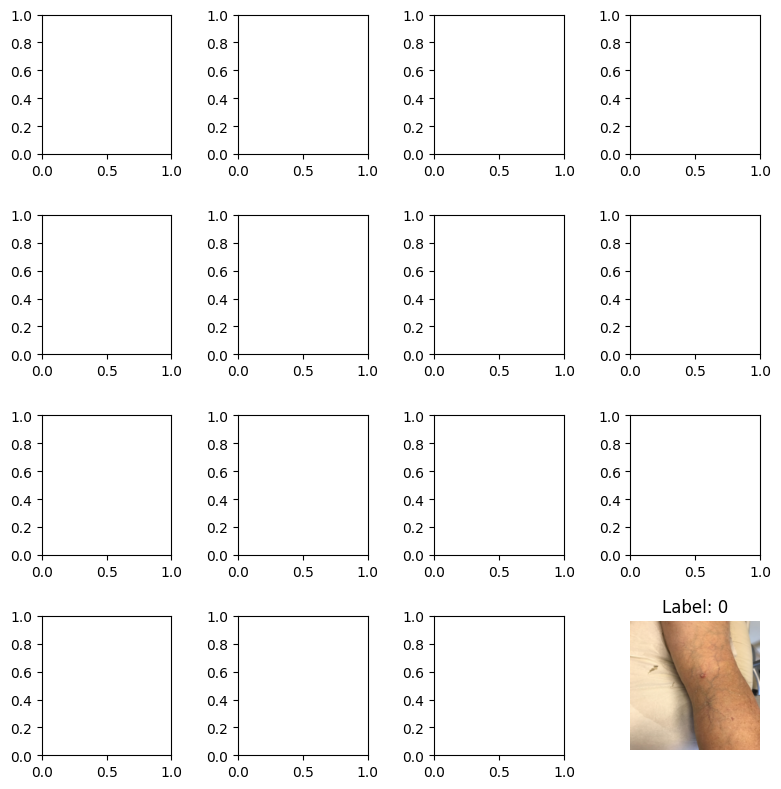

In [9]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler


# Load metadata
file_path = "C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer/release_midas.xlsx"
df = pd.read_excel(file_path)


# Define image directory (same folder as the Excel sheet)
image_dir = os.path.dirname(file_path)

# Convert categorical columns to string before encoding
df = df.astype(str)

# Encode categorical variables
label_encoders = {}
categorical_cols = ['midas_gender', 'midas_fitzpatrick', 'midas_ethnicity', 'midas_race']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Convert numerical columns to float and handle errors
numerical_cols = ['midas_age', 'length_(mm)', 'width_(mm)']
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')

# Normalize numerical variables
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols].fillna(0))

# Define target variable
df['target'] = df['midas_melanoma'].map({'yes': 1, 'no': 0})

# Remove rows with missing labels
df = df.dropna(subset=['target']).reset_index(drop=True)

# Debugging: Check unique label values and types
print("Unique label values:", df["target"].unique())
print("Label data type:", df["target"].dtype)

# Remove rows where the image file is missing
def file_exists(filename):
    possible_paths = [
        os.path.join(image_dir, filename),
        os.path.join(image_dir, filename.replace('.jpg', '.jpeg')),
        os.path.join(image_dir, filename.replace('.jpeg', '.jpg'))
    ]
    return any(os.path.exists(path) for path in possible_paths)

df = df[df['midas_file_name'].apply(file_exists)].reset_index(drop=True)

# Define dataset class
class MRAMIDASDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe
        self.image_dir = image_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Load image with flexible file extension handling
        img_filename = row['midas_file_name']
        img_path = os.path.join(self.image_dir, img_filename)
        
        if not os.path.exists(img_path):
            # Try alternative extensions
            img_path_jpeg = img_path.replace('.jpg', '.jpeg')
            img_path_jpg = img_path.replace('.jpeg', '.jpg')
            if os.path.exists(img_path_jpeg):
                img_path = img_path_jpeg
            elif os.path.exists(img_path_jpg):
                img_path = img_path_jpg
            else:
                raise FileNotFoundError(f"Image not found: {img_filename}")
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Load metadata
        metadata_values = row[categorical_cols + numerical_cols].values.astype(float)
        metadata = torch.tensor(metadata_values, dtype=torch.float32)
        
        # Ensure label is an integer before creating tensor
        label = int(row['target'])  # Convert from potential object type
        label = torch.tensor(label, dtype=torch.int64)
        
        return image, metadata, label

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset and dataloader
dataset = MRAMIDASDataset(df, image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


import torchvision.utils as vutils

# Get a batch of images
data_iter = iter(dataloader)
images, metadata, labels = next(data_iter)

# Convert images to numpy for visualization
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean  # Unnormalize
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Display images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()

for i in range(16):
    imshow(images[i], title=f"Label: {labels[i].item()}")

plt.tight_layout()
plt.show()
